# Tutorial

This document provides an overview of the structure of the code
and how to access basic information about calculations.
If you have not installed DFTK yet, please refer to the Installation instructions.

Basic familiarity with the concepts of plane-wave density functional theory
is assumed in this tutorial. Take a look at the Introductory resources
for some broader introductory material. There is also a Mathematical Tutorial.

> **Mathematical tutorial**
>
> There is also a Mathematical Tutorial
> for more mathematically-minded readers, where no familiarity
> with condensed-matter simulations is assumed.

> **Convergence parameters in the documentation**
>
> We use rough parameters in order to be able
> to automatically generate this documentation very quickly.
> Therefore results are far from converged.
> Tighter thresholds and larger grids should be used for more realistic results.
> See also the example on Performing a convergence study.

## Setting up a first calculation

For our discussion we will use the classic example of computing the LDA ground state
of the [silicon crystal](https://www.materialsproject.org/materials/mp-149).
Performing such a calculation roughly proceeds in three steps.

In [1]:
using DFTK
using Plots
using Unitful
using UnitfulAtomic
using PseudoPotentialData

# 1. Define lattice and atomic positions
a = 5.431u"angstrom"          # Silicon lattice constant
lattice = a / 2 * [[0 1 1.];  # Silicon lattice vectors
                   [1 0 1.];  # specified column by column
                   [1 1 0.]];

By default, all numbers passed as arguments are assumed to be in atomic
units.  Quantities such as temperature, energy cutoffs, lattice vectors, and
the k-point grid spacing can optionally be annotated with Unitful units,
which are automatically converted to the atomic units used internally. For
more details, see the [Unitful package
documentation](https://juliaphysics.github.io/Unitful.jl/stable/) and the
[UnitfulAtomic.jl package](https://github.com/sostock/UnitfulAtomic.jl).

We use a pseudodojo pseudopotential
(see [PseudoPotentialData](https://github.com/JuliaMolSim/PseudoPotentialData.jl)
 for more details on `PseudoFamily`):

In [2]:
pd_lda_family = PseudoFamily("dojo.nc.sr.lda.v0_4_1.standard.upf")
Si = ElementPsp(:Si, pd_lda_family)

# Specify type and positions of atoms
atoms     = [Si, Si]
positions = [ones(3)/8, -ones(3)/8]

2-element Vector{Vector{Float64}}:
 [0.125, 0.125, 0.125]
 [-0.125, -0.125, -0.125]

Note that DFTK supports a few other ways to supply atomistic structures,
see for example the sections on AtomsBase integration
and Input and output formats for details.

In [3]:
# 2. Select model and basis
model = model_DFT(lattice, atoms, positions; functionals=LDA())

kgrid = KgridSpacing(0.3 / u"bohr")  # Regular k-point grid (Monkhorst-Pack grid)
#                                      with spacing 0.3/bohr between k-points
# kgrid = [4, 4, 4]                    Alternative: Number of k-points per dimension
Ecut = 7              # kinetic energy cutoff
# Ecut = 190.5u"eV"  # Could also use eV or other energy-compatible units

basis = PlaneWaveBasis(model; Ecut, kgrid)
# Note the implicit passing of keyword arguments here:
# this is equivalent to PlaneWaveBasis(model; Ecut=Ecut, kgrid=kgrid)

# 3. Run the SCF procedure to obtain the ground state
scfres = self_consistent_field(basis, tol=1e-5);

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime 
---   ---------------   ---------   ---------   ----   ------
  1   -8.505325425301                   -0.93    5.2    4.97s
  2   -8.508294764250       -2.53       -1.79    1.0    4.15s
  3   -8.508456675350       -3.79       -2.87    1.5   70.8ms
  4   -8.508482913188       -4.58       -3.04    2.6   51.9ms
  5   -8.508483097444       -6.73       -3.21    1.0   27.2ms
  6   -8.508483220953       -6.91       -4.60    1.0   27.2ms
  7   -8.508483227459       -8.19       -4.68    2.9   39.7ms
  8   -8.508483227631       -9.76       -5.68    1.0   42.0ms


## Inspecting the results

That's it! Now you can get various quantities from the result of the SCF.
For instance, the different components of the energy:

In [4]:
scfres.energies

Energy breakdown (in Ha):
    Kinetic             3.0841992 
    AtomicLocal         -2.3554939
    AtomicNonlocal      1.3116730 
    Ewald               -8.3979253
    PspCorrection       0.3948680 
    Hartree             0.5559235 
    Xc                  -3.1017278

    total               -8.508483227631

Eigenvalues:

In [5]:
stack(scfres.eigenvalues)

7×8 Matrix{Float64}:
 -0.264799  -0.235353   -0.179075   …  -0.18931    -0.112073   -0.106307
  0.174322   0.0295305  -0.0825382     -0.0265568  -0.112073   -0.106307
  0.174322   0.146146    0.129857       0.0347384   0.0686542   0.0309529
  0.174322   0.146146    0.129857       0.125209    0.0686542   0.0309529
  0.26715    0.247825    0.229556       0.26304     0.198144    0.329875
  0.26715    0.302404    0.297035   …   0.349551    0.198144    0.329996
  0.267152   0.302404    0.297035       0.362164    0.542205    0.356807

`eigenvalues` is an array (indexed by k-points) of arrays (indexed by
eigenvalue number).

The resulting matrix is 7 (number of computed eigenvalues) by 8
(number of irreducible k-points). There are 7 eigenvalues per
k-point because there are 4 occupied states in the system (4 valence
electrons per silicon atom, two atoms per unit cell, and paired
spins), and the eigensolver gives itself some breathing room by
computing some extra states (see the `bands` argument to
`self_consistent_field` as well as the `AdaptiveBands` documentation).
There are only 8 k-points (instead of 4x4x4) because symmetry has been used to reduce the
amount of computations to just the irreducible k-points (see
[Crystal symmetries](https://docs.dftk.org/stable/developer/symmetries/)
for details).

We can check the occupations ...

In [6]:
stack(scfres.occupation)

7×8 Matrix{Float64}:
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

... and density, where we use that the density objects in DFTK are
indexed as ρ[ix, iy, iz, iσ], i.e. first in the 3-dimensional real-space grid
and then in the spin component.

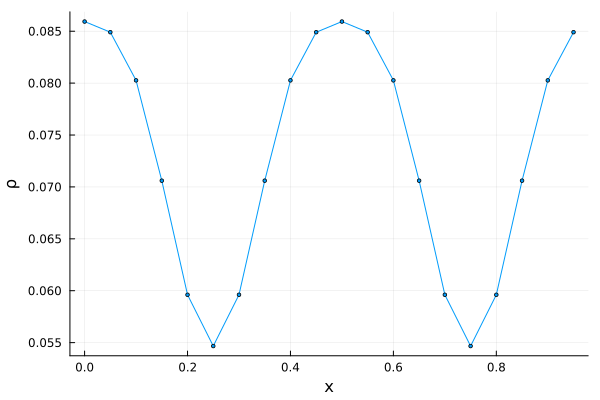

In [7]:
rvecs = collect(r_vectors(basis))[:, 1, 1]  # slice along the x axis
x = [r[1] for r in rvecs]                   # only keep the x coordinate
plot(x, scfres.ρ[:, 1, 1, 1], label="", xlabel="x", ylabel="ρ", marker=2)

We can also perform various postprocessing steps:
We can get the Cartesian forces (in Hartree / Bohr):

In [8]:
compute_forces_cart(scfres)

2-element Vector{StaticArraysCore.SVector{3, Float64}}:
 [-2.100305622389186e-14, -2.109343945899912e-14, -2.134852162017543e-14]
 [2.110599633658569e-14, 2.1051881801780517e-14, 2.1279860797399834e-14]

As expected, they are numerically zero in this highly symmetric configuration.
We could also compute a band structure: we compute the bands along
a k-point line (determined automatically) and plot the result:

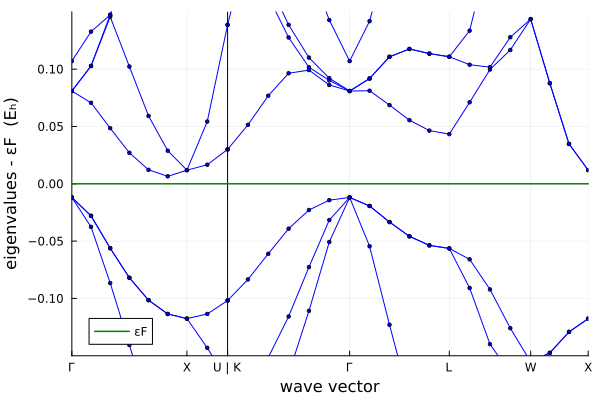

In [9]:
bands1 = compute_bands(scfres; kline_density=10)
plot_bandstructure(bands1)

Next we want to plot a density of states.
We can use the `scfres` directly, but the resulting DOS is quite sharp:

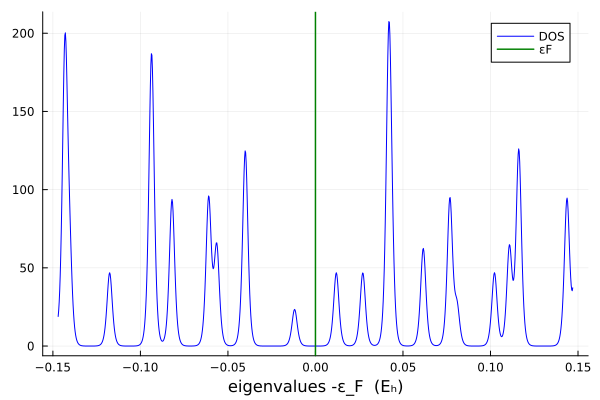

In [10]:
plot_dos(scfres; temperature=1e-3, smearing=Smearing.FermiDirac())

To get a better result we first increase the kgrid to get a better
discretisation of the Brillouin zone, then re-do the plot:

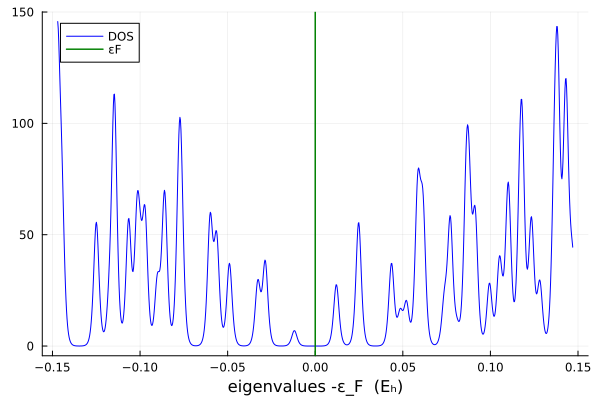

In [11]:
bands2 = compute_bands(scfres, MonkhorstPack(6, 6, 6))
plot_dos(bands2; temperature=1e-3, smearing=Smearing.FermiDirac())

Note, that some other codes would refer to the functionality
we provide with `compute_bands` as "performing a NSCF calculation".

> **Where to go from here**
>
> - **Background on DFT:**
>   * Introductory resources,
>   * Periodic problems,
>   * Introduction to density-functional theory,
>   * Self-consistent field methods
>   * Further Introductory resources
> - **Running calculations:**
>   * Temperature and metallic systems
>   * Pseudopotentials
>   * Performing a convergence study
>   * Computing Elastic constants
>   * Geometry optimization
>   * AtomsBase integration and wider ecosystem: Building / reading structures etc.
> - **Tips and tricks:**
>   * Using DFTK on compute clusters,
>   * Using DFTK on GPUs,
>   * Saving SCF results on disk and SCF checkpoints